In [1]:
import autograd.numpy as np
import autograd.scipy as sp
from autograd.scipy import special
from autograd import grad, hessian, hessian_vector_product, hessian, jacobian
import matplotlib.pyplot as plt
%matplotlib inline  

from copy import deepcopy

from scipy import optimize

import math
import time

import valez_finite_VI_lib as vi
from data_set_lib import DataSet
import generic_optimization_lib as packing

In [2]:
#np.random.seed(12321)

alpha = 10 # IBP parameter
num_samples = 50 # Data set size
x_dim = 4 # dimension
sigma_a = 3.0 ** 2
sigma_eps = 1.0 ** 2 # variance of noise
k_inf = 5 # take to be large for a good approximation to the IBP
pi_true, z_true, mu_true, a_true, x = vi.generate_data(num_samples, x_dim, k_inf, sigma_a, sigma_eps, alpha)
k_approx = k_inf

tau_init, nu_init, phi_mu_init, phi_var_init = \
    vi.initialize_parameters(num_samples, x_dim, k_approx)

params_init = packing.pack_params(deepcopy(tau_init), deepcopy(phi_mu_init),
                                  deepcopy(phi_var_init), deepcopy(nu_init))

hyper_params = packing.pack_hyperparameters(alpha, sigma_a, sigma_eps)

data_set = DataSet(x, k_approx, alpha, sigma_eps, sigma_a)

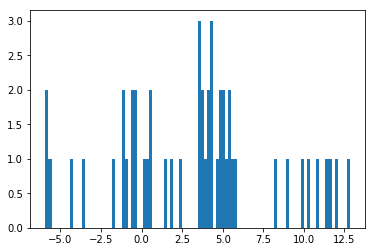

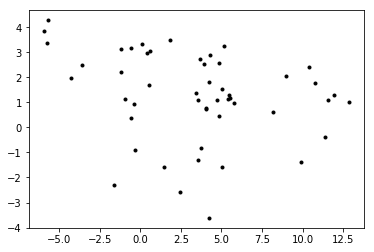

In [3]:
col = 0
plt.figure()
plt.hist(data_set.x[:, col], bins=100);

col1 = 0
col2 = 1
plt.figure()
plt.plot(data_set.x[:, col1], data_set.x[:, col2], 'k.');

In [ ]:
# Distributions given sufficient statistics.

def log_p_x_conditional(x, z, a, a2, sigma_eps):
    x_centered = x - np.matmul(z, a.T)
    var_eps = sigma_eps
    return -0.5 * np.sum(x_centered ** 2) / var_eps


def log_p_z(z, pi):
    return np.sum(z * np.log(pi) + (1 - z) * np.log(1 - pi))


def log_p_a(a, sigma_a):
    var_a = sigma_a
    return -0.5 * np.sum(a ** 2) / var_a


def log_p_pi(pi, alpha, k_approx):
    param = alpha / float(k_approx)
    return np.sum((param - 1) * np.log(pi))


def log_lik(x, z, a, pi, sigma_eps, sigma_a, alpha, k_approx):
    return \
        log_p_x_conditional(x, z, a, sigma_eps) + \
        log_p_pi(pi, alpha, k_approx) + log_p_z(z, pi) + log_p_a(a, sigma_a)



In [11]:
z = z_true.astype(float, copy=True)
a = deepcopy(a_true.T)
pi = deepcopy(pi_true)

get_z_conditional_params = grad(vi.log_lik, argnum=1)
get_a_conditional_params = grad(vi.log_lik, argnum=2)
get_pi_conditional_params = grad(vi.log_lik, argnum=3)

ll = vi.log_lik(x, z, a, pi, sigma_eps, sigma_a, alpha, k_approx)

In [47]:
z_conditional_params = get_z_conditional_params(x, z, a, pi, sigma_eps, sigma_a, alpha, k_approx)
z_logsumexp = sp.misc.logsumexp(z_conditional_params, 1)
z_means = np.exp(z_conditional_params - np.broadcast_to(z_logsumexp, (k_approx, num_samples)).T)
assert np.all(np.abs(np.sum(z_means, 1) - 1) < 1e-8)

In [48]:
a_conditional_params = get_z_conditional_params(x, z, a, pi, sigma_eps, sigma_a, alpha, k_approx)
